# Exercício 3: B)
Usando algoritmos implementados na questão 2, aproxime as funções abaixo. Compare os
resultados com as curvas exatas, para o caso dos itens b e c e apresente para cada caso a
curva do erro médio de treinamento com relação ao número de épocas e a curva do erro médiocom o conjunto de validação. Faça uma análise comparativa sobre a convergência de cada um
dos algoritmos.<br>
a) a função lógica XOR<br>
b) f(x) = sen(pi*x)/(pi*x), 0 <= x <= 4


## Geração de dados

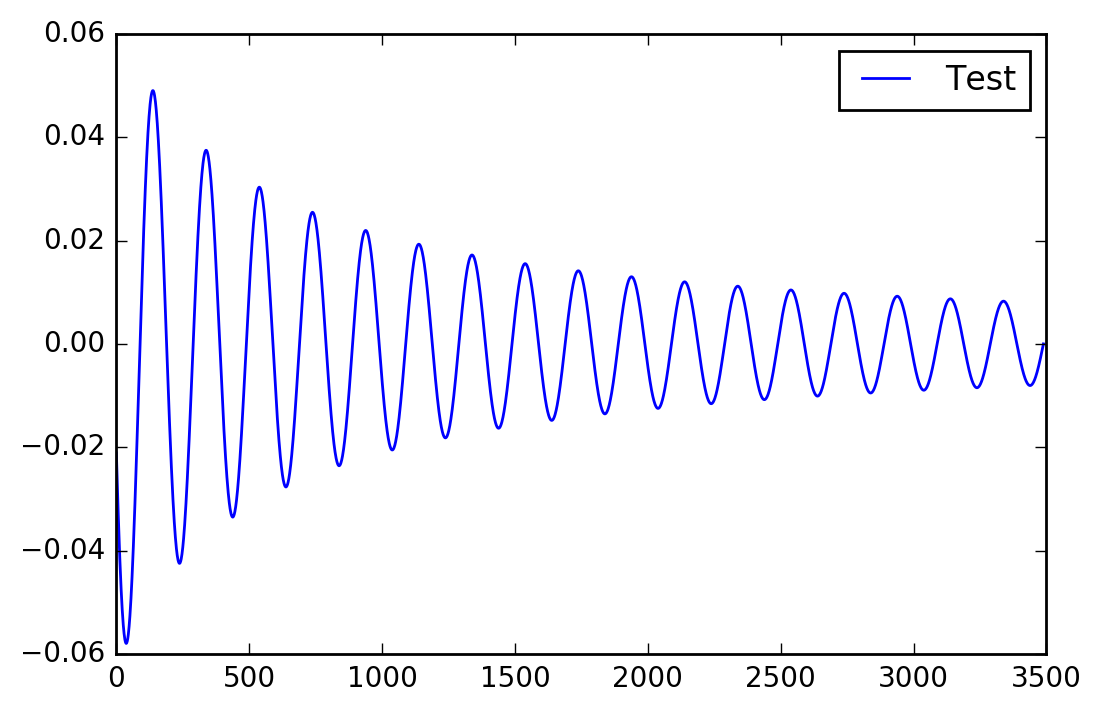

In [27]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle

function_to_learn = lambda x: np.sin(np.pi*x)/(np.pi*x) #+ 0.01*np.random.randn(*x.shape)

all_X = np.arange(0.01, 40.01, 0.01, 'float')
all_X = [function_to_learn(x) for x in all_X]

all_data_X = np.zeros(shape=(int(len(all_X)-9), 10))
i = 0
for index, elem in enumerate(all_X):
    row_X = all_X[index:10+index]
    if len(row_X) == 10:
        all_data_X[i] = row_X
        i = i + 1

test_X = all_data_X.copy()
test_X = test_X[500:]

all_X = np.arange(0.01, 4.01, 0.01, 'float')
all_X = [function_to_learn(x) for x in all_X]
all_data_X = np.zeros(shape=(int(len(all_X)-9), 10))
i = 0
for index, elem in enumerate(all_X):
    row_X = all_X[index:10+index]
    if len(row_X) == 10:
        all_data_X[i] = row_X
        i = i + 1

all_data_y = [x[-1] for x in all_data_X]
all_data_y = np.reshape(all_data_y, (len(all_data_y), 1))
all_data_y = np.roll(all_data_y,-1)
all_data_X = all_data_X[:-1]
all_data_y = all_data_y[:-1]

all_data_X, all_data_y = shuffle(all_data_X, all_data_y, random_state=0)

train_size = int(len(all_data_X)*0.75)
train_X = all_data_X[:train_size]
train_y = all_data_y[:train_size]
val_X = all_data_X[train_size:]
val_y = all_data_y[train_size:]

test_y = [x[-1] for x in test_X]
test_y = np.reshape(test_y, (len(test_y), 1))
test_y = np.roll(test_y,-1)
test_X = test_X[:-1]
test_y = test_y[:-1]

plt.plot(test_y, label='Test')
plt.legend()
_ = plt.ylim()


### Demonstração da geração de dados

In [20]:
print('{0} => {1}'.format(train_X[0], train_y[0]))
print('{0} => {1}'.format(train_X[1], train_y[1]))
print('{0} => {1}'.format(train_X[2], train_y[2]))
print('{0} => {1}'.format(train_X[3], train_y[3]))

[0.57161993 0.5583424  0.54498939 0.53156827 0.5180864  0.50455115
 0.49096992 0.47735008 0.463699   0.45002406] => [0.43633259]
[-0.18006326 -0.18415708 -0.18800612 -0.19161092 -0.19497221 -0.19809085
 -0.20096788 -0.20360449 -0.20600203 -0.208162  ] => [-0.21008606]
[-0.09094568 -0.09064183 -0.0902505  -0.08977258 -0.08920902 -0.08856083
 -0.08782914 -0.08701511 -0.08612    -0.08514512] => [-0.08409186]
[-0.12380575 -0.11892774 -0.11398784 -0.10899127 -0.10394325 -0.098849
 -0.09371372 -0.08854258 -0.08334074 -0.07811333] => [-0.07286546]


## Rede Neural

In [24]:
import tensorflow as tf
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42
tf.set_random_seed(RANDOM_SEED)

tf.reset_default_graph()

learning_rate = 0.001
epoch = 1000
interval = 25
batch_size = 25
n_batches = train_X.shape[0]//batch_size

# Layer's sizes
x_size = 10   # Number of input node
h_size = 10   # Number of hidden nodes
y_size = 1   # Number of outcomes

# Symbols
X = tf.placeholder(tf.float32, shape=[None, x_size], name='X')
y = tf.placeholder(tf.float32, shape=[None, y_size], name='y')

# Weight initializations
w1 = tf.Variable(tf.random_normal(shape=(x_size, h_size)))
b1 = tf.Variable(tf.random_normal(shape=[h_size]))
w2 = tf.Variable(tf.random_normal(shape=(h_size, y_size)))
b2 = tf.Variable(tf.random_normal(shape=[y_size]))

# Operations
hidden_output = tf.nn.tanh(tf.add(tf.matmul(X, w1), b1))
final_output = tf.nn.tanh(tf.add(tf.matmul(hidden_output, w2), b2), name='final_output')

# Cost Function
loss = tf.reduce_mean(tf.square(final_output - y))
#loss = tf.nn.l2_loss(final_output - y)
# Optimizer
# GD
#optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
optimizer = tf.train.AdamOptimizer().minimize(loss)

# Momentum GD
#optimizer = tf.train.MomentumOptimizer(learning_rate, 0.5).minimize(loss)

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Run SGD
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

# Training
print('Training the model...')
losses = {'train':[], 'validation':[]}

for e in range(epoch):
    idxs = np.random.permutation(train_X.shape[0]) #shuffled ordering
    random_X = train_X[idxs]
    random_y = train_y[idxs]
    for i in range(n_batches):
        batch_X = random_X[i * batch_size:(i+1) * batch_size]
        batch_y = random_y[i * batch_size:(i+1) * batch_size]
        sess.run(optimizer,feed_dict = {X: batch_X, y:batch_y})
    if e % interval == 0:
        train_loss = sess.run(loss, feed_dict={X: train_X, y: train_y})
        val_loss   = sess.run(loss, feed_dict={X: val_X, y: val_y})
        losses['train'].append(train_loss)
        losses['validation'].append(val_loss)
        print('Epoch', e, '|',
              'Batch', i, '|',
              'Train Loss:', train_loss , '|',
              'Validation Loss:', val_loss)

save_path = saver.save(sess, './my_test_model',global_step=1000)
print("Model saved in path: %s" % save_path)
sess.close()

Training the model...
Epoch 0 | Batch 10 | Train Loss: 0.97035426 | Validation Loss: 0.8165085
Epoch 25 | Batch 10 | Train Loss: 0.0017430942 | Validation Loss: 0.001545672
Epoch 50 | Batch 10 | Train Loss: 0.0012498042 | Validation Loss: 0.0011854244
Epoch 75 | Batch 10 | Train Loss: 0.0009043278 | Validation Loss: 0.00084039144
Epoch 100 | Batch 10 | Train Loss: 0.00064897025 | Validation Loss: 0.00062540383
Epoch 125 | Batch 10 | Train Loss: 0.00047923552 | Validation Loss: 0.00045137224
Epoch 150 | Batch 10 | Train Loss: 0.0003691881 | Validation Loss: 0.00035450037
Epoch 175 | Batch 10 | Train Loss: 0.00029504366 | Validation Loss: 0.00026907466
Epoch 200 | Batch 10 | Train Loss: 0.0002441171 | Validation Loss: 0.00021088994
Epoch 225 | Batch 10 | Train Loss: 0.00020352073 | Validation Loss: 0.00018160266
Epoch 250 | Batch 10 | Train Loss: 0.000179466 | Validation Loss: 0.00014791667
Epoch 275 | Batch 10 | Train Loss: 0.00015655994 | Validation Loss: 0.00014011243
Epoch 300 | Batc

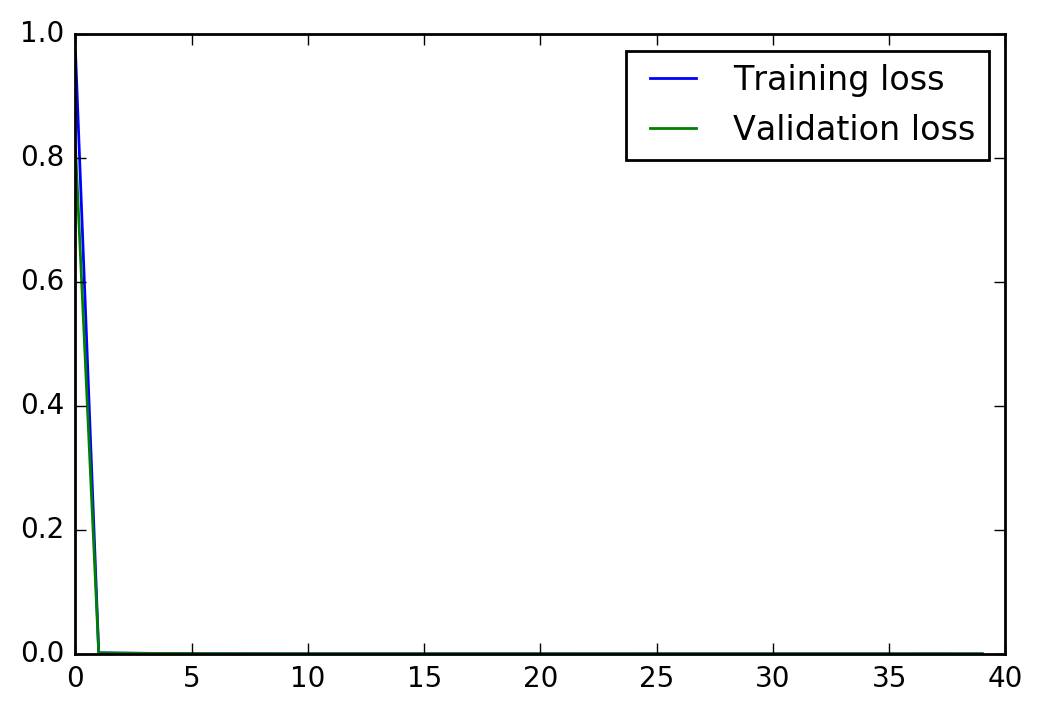

In [25]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Testando a Rede

INFO:tensorflow:Restoring parameters from ./my_test_model-1000
3490
3490


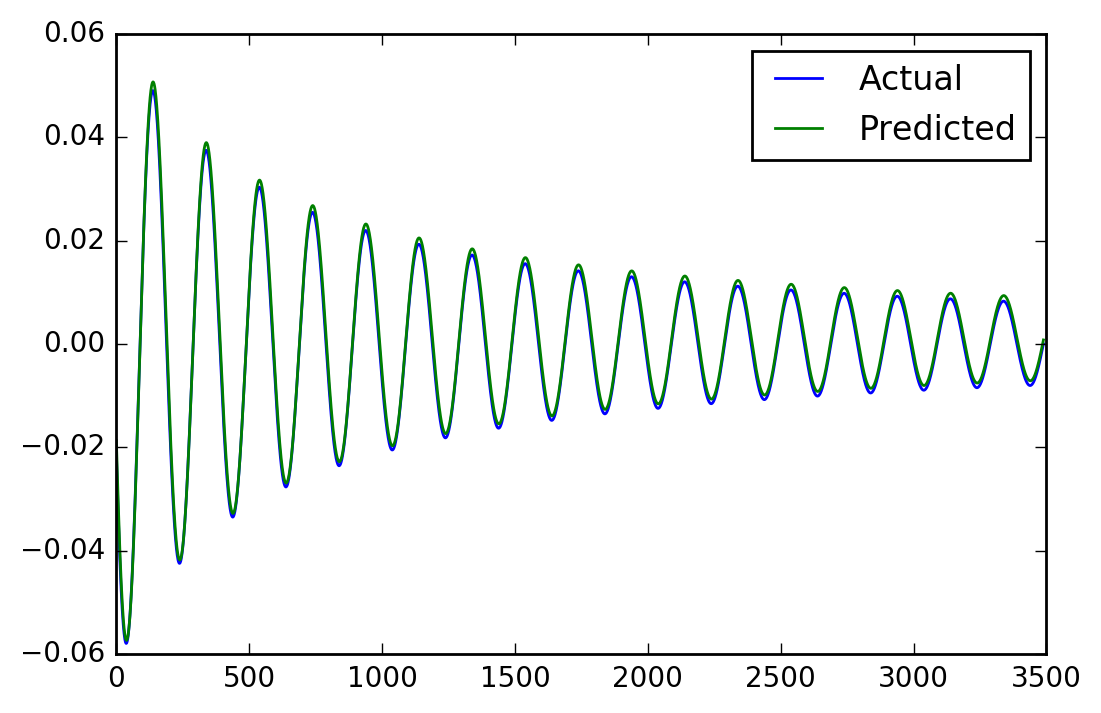

In [28]:
# Import model
with tf.Session() as sess:    
    saver = tf.train.import_meta_graph('./my_test_model-1000.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./'))
    
    graph = tf.get_default_graph()
    X = graph.get_tensor_by_name("X:0")
    final_output = graph.get_tensor_by_name("final_output:0")
    
    results = {'actual':[], 'predicted':[]}
    for i in range(len(test_X)):
        predicted = sess.run(final_output, feed_dict={X: [test_X[i]]})
        results['actual'].append(test_y[i])
        results['predicted'].append(predicted[0])

print(len(results['actual']))
print(len(results['predicted']))
plt.plot(results['actual'], label='Actual')
plt.plot(results['predicted'], label='Predicted')
plt.legend()
_ = plt.ylim()